# <center>  **Data Wrangling** 

<center> Data Loading

#### **Data Loading**

In [109]:
# Import all the Necessary Packages
import pandas as pd
import numpy as np
import matplotlib
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.style.use('dark_background')

In [110]:
# Import the data and see what it looks like
path = r'C:\Users\jdrel\OneDrive\Documents\Data_Science\Springboard\Capstone-2\data\raw\kddcup.data_10_percent'
data = pd.read_csv(path)

The dataset and column names can be found in the about section on the data's webpage: [KDD Dataset](https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The initial dataset that I worked with was only 10% of the total dataset and does not include the special test set with different attack types. My computer is only so strong so at first I will create a model with the first 10% and if my algorithms are efficient enough to give me the time to try the whole dataset then I will try that as well.

In [111]:
# I copy and pasted the column names from the website into this list
data.columns = ["duration", "protocol_type", "service", "flag", "src_bytes",
                "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
                "num_failed_logins", "logged_in", "num_compromised",
                "root_shell", "su_attempted", "num_root", "num_file_creations",
                "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
                "is_guest_login", "count", "srv_count", "serror_rate","srv_serror_rate",
                "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
                "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
                "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", 
                "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels"]
data.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.


#### **First Look**

The easiest way to get a grasp of the dataset is to use the function "ProfileReport." ProfileReport is a function from the y-data profiling package that takes a dataset and performs all of the starting analyses that reveal problems to clean up, or avenues to explore. I did not run this function in the uploaded version because the report was so large that it required me to store the entire notebook in git lfs storage. 

In [ ]:
# Report exploring all of the variables in the data
# Dark Mode is enabled for my eyes
profile = ProfileReport(data, 
                        title = 'Network Intrusion Exploration',
                        dark_mode = True)
profile

This report has a lot of important information:

-  No missing values: This is a really nice fact about this dataset that there are no missing values. Because this is dataset on computer networks run by MIT Lincoln labs it is not surprising that the data is this high quality but nonetheless with the amount of data in the dataset having no missing values is impressive.
-  Constant features: Features that are constants are useless as they give no information to any model that we could use. They may contain some information in the entirety of the dataset but they were constant in this 10% sub-section
-  Skewed features: To fix this we can scale the data so that only the trends in the data will be captures by the model and not arbitrarily high numbers
-  High numbers of zeros: This will be addressed in feature selection. We can run tests such as lasso regularization to determine which features have an impact on the target variable. If a feature with a large amount of zeros has a large impact then the amount of zeros doesn't matter and if there is no impact then we can drop the feature. 

-  Large Multicolinearity: This is a major problem that I will take most of the notebook to address. With multicolinearity predictions can be unreliable and it is impossible to isolate which feature is causing the target variable's behavior.

**Constant Features**

Both "num_outbound_cmds" and "is_host_login" have a constant value so they can be dropped. This step may be changed if I use the entire dataset.

In [112]:
# Use the drop methods to get rid of the constants
data = data.drop(columns = ['num_outbound_cmds', 'is_host_login'], axis = 1)

Now we separate the data into the feature variables (X) and the target variable (y). With the features dataframe we can use the pd.get_dummies function to create dummy features for all the categories in the categorical columns. This will make it possible to analyze all the features for multicolinearity and then use lasso regularization to determine the most important features.

In [113]:
# Only use the X data so that it is easy to test for multicolinearity
X_data = data.drop('labels', axis = 1)

# Find the categorical columns that need to be made numerical for analysis
cat_cols = list(X_data.select_dtypes(include = 'object').columns)

# Creating a completely numerical dataset that is usable for analysis
x_num_data = pd.get_dummies(X_data, columns = cat_cols, 
                        # When testing for multi-co-linearity it is important to drop one of the dummies
                        # so that that column doesn't get flagged
                            drop_first = True)

**Skewed Features**

Skewed features are a problem as they make it hard for models to accurately describe interactions between different features because the arbitrary size of some feature will completely warp the math. To fix this we can scale the features with StandardScaler so as to preserve the nature of the feature without destroying the model by its size.



In [114]:
# Create the scaler object
scaler = StandardScaler()
# fit the scaler to the dataset
scaler.fit(x_num_data)
# Scale the dataset
x_num_data_scaled = pd.DataFrame(scaler.transform(x_num_data), columns = x_num_data.columns)

Store the features and target dataframes as X and y so that it is easy to code for the rest of the notebook.

In [115]:
# Define X as all the feature variables in numerical form scaled
X = x_num_data_scaled
# Define y as a binary target variable where 0 is no attack and 1 is an attack
y = np.where(data['labels'] == 'normal.', 0, 1)

## <center>**Multicolinearity**

The most glaring problem from the profile report is the amount of variables that have high correlations with each other. This is because a sizable portion of the columns measure similar things. For instance "srv_rerror_rate" and "dst_host_srv_rerror_rate" are both measuring the rate at which a connection request to a server is rejected but the former is recording only last two seconds while the latter is using the time frame of the last 100 connections to the server. While they both have slightly different information the information is so similar that is impossible to leave both features in the dataset. The challenge now is to go through the dataset and try to find all instances of similar features and either combine them or discard them.

Below is the starting point on how correlated the features are to themselves when every feature is numeric. It is not as extreme as the graph inside the profiling report because much the feature set contains contain dummy variables from columns where the first category has been dropped. Those columns still contain some colinearity but not as much as the original numerical columns. 

For the heatmaps below I defined a function that would allow take simple inputs to give myself whatever heatmap I needed. I used the absolute value of the correlations because a negative correlation in multicolinearity is just as bad as a positive correlation. 

In [71]:
# Function to get rid of all the diagonals in correlation heatmaps
def zero_diagonal_heatmap(dfx, min = 0, max = None, color_map = None, threshhold = 0):
    # give the max a base value
    if max is None:
        max = len(dfx)
    # Create a numpy matrix that is easy to manipulate
    cm = np.matrix(abs(dfx.iloc[:,min:max].corr()))
    # Create a loop that replaces all the diagonal values with 0
    for i in range(len(cm)):
        # Loop thorough the other axis of values
        for j in range(len(cm)):
            # All diagonal values happen when i == j
            if i == j:
                # set the diagonal value equal to 0
                cm[i,j] = 0
    df_cm = pd.DataFrame(cm, columns = list(dfx.columns)[min:max], index = list(dfx.columns)[min:max])
    # Make the plot bigger
    plt.figure(figsize=(12, 8))
    # Plot the heatmap
    ax = sns.heatmap(df_cm, cmap = color_map, center = threshhold, vmin = 0, vmax = 1);

The brighter the square, the higher the colinearity. The numbers represent which number feature is being shown.

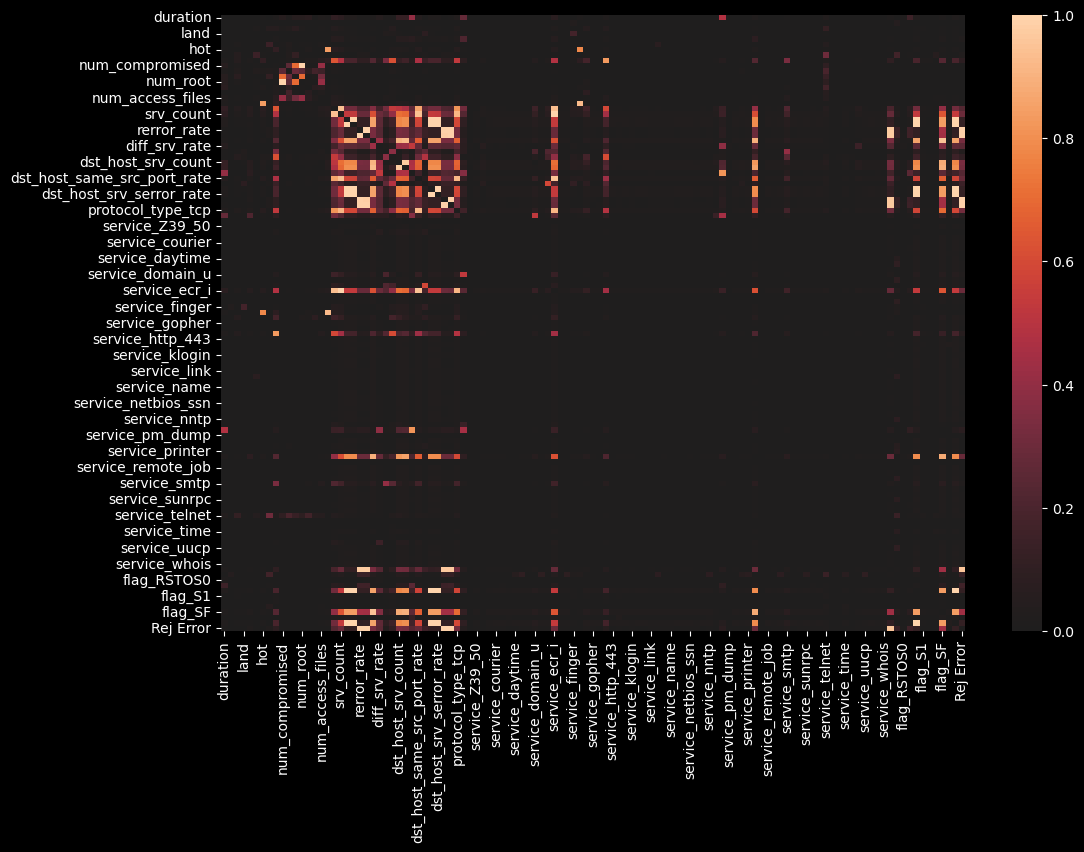

In [75]:
zero_diagonal_heatmap(X)

The heatmap shows a very concerning square from feature 15 to 39. While there are other concerns if I can clean up that square many of the other problems will go away as well.

Cleaning up the colinearity is not easy. While it may seem tempting to drop all the problematic columns, there is too much important information that is contained within those columns. Most of the heatmap that has no correlation are dummy variables that are iterations of the same variable and contain less information. 

The first attempt that I made was look at the features in the dataset and see if there were clear groups of features that had clear real world explanations for their high correlations. This was too hard as I am not familiar with this subject matter and the amount of groupings felt endless. Next I decided to zoom in on bright spot of the heatmap to see if there were any obvious groupings. 

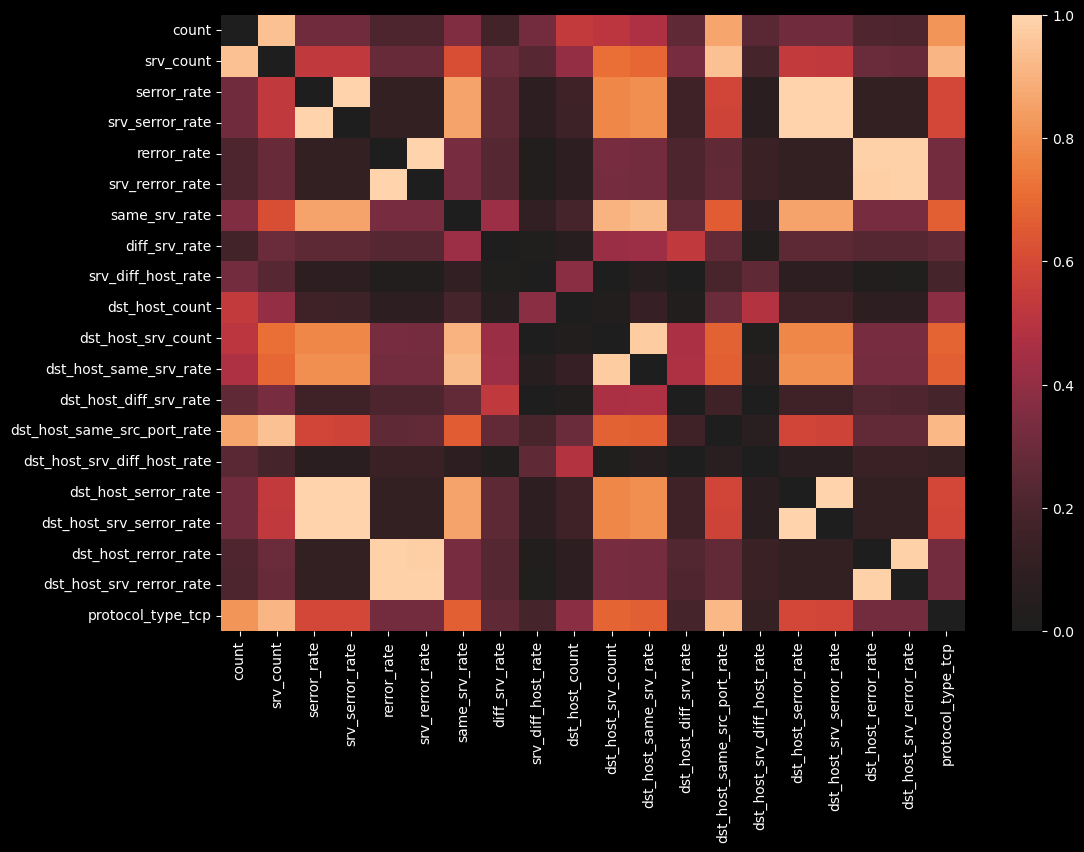

In [82]:
zero_diagonal_heatmap(dfx = X, min = 17, max = 37);

In the heatmap above all the features that have serror or rerror in their name are boxed together and had high levels of correlation. Given their clear connection in the real world and the high correlation I combined each of the variables into one feature variable by taking the maximum value of the four for each row. This way if one of the four variables has a high error rate it will get captured by the column whereas a low error in all four will also get captured by the column. Since they have such a high correlation there is not much information loss by combining them. 

In [116]:
# Define the Syn Error columns
serror = ['serror_rate', 'srv_serror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate']

# Define the Syn Error columns
rerror = ['rerror_rate', 'srv_rerror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

# Drop the redundant columns
df = x_num_data_scaled.drop(columns = [*serror, *rerror])

# Create new Syn Error column as mean of the former Syn Error columns
df['Syn Error'] = X[serror].max(axis = 1)


# Create new Syn Error column as mean of the former Syn Error columns
df['Rej Error'] = X[rerror].max(axis = 1)

Nothing else was obvious from the heatmap above so I created a function that produces dictionary with each features binded to the number of multicolinearities it has. I set the threshhold to 0.7 as a starting point. 

In [106]:
# Create a function that takes a dataframe and a correlation level 
def corr_dict(dfx, corr = 0.7):
    # Create the correlation with absolute values to measure colinearity
    corr_mat = abs(dfx.corr()) > corr   # type: ignore
    # Define the dictionary outside the function for uses
    global correl_dict
    # Create a dictionary with sorted values so that it is easy to see the next steps
    correl_dict = dict(corr_mat.sum().sort_values(ascending = False)) 
    # Subtract each value by one for the self correlation on the diagonal
    correl_dict = {key: value - 1 for key, value in correl_dict.items() if value != 1}
    # Print the dictionary
    print(correl_dict)

With this function we can plug in the dataframe df and see what it is that we are supposed to do next.

In [117]:
corr_dict(df)

{'dst_host_srv_count': 8, 'Syn Error': 6, 'flag_SF': 6, 'service_private': 6, 'same_srv_rate': 6, 'dst_host_same_srv_rate': 6, 'flag_S0': 6, 'srv_count': 5, 'service_ecr_i': 5, 'protocol_type_tcp': 4, 'count': 4, 'dst_host_same_src_port_rate': 4, 'service_ftp': 2, 'is_guest_login': 2, 'num_compromised': 2, 'hot': 2, 'flag_REJ': 1, 'dst_host_diff_srv_rate': 1, 'Rej Error': 1, 'service_other': 1, 'num_root': 1, 'su_attempted': 1, 'logged_in': 1, 'service_http': 1}


This dictionary has a ton of features that would be hard to evaluate individually. Instead I can clean the features that have four or more colinearities to clean up the features faster. I also want to omit 'Syn Error' from this process until I need to because it is a representation of four different features.

The next heatmap is a binary color scheme where white is above a correlation threshhold. I picked 0.9 to start with so that I can deal with the obvious cases.

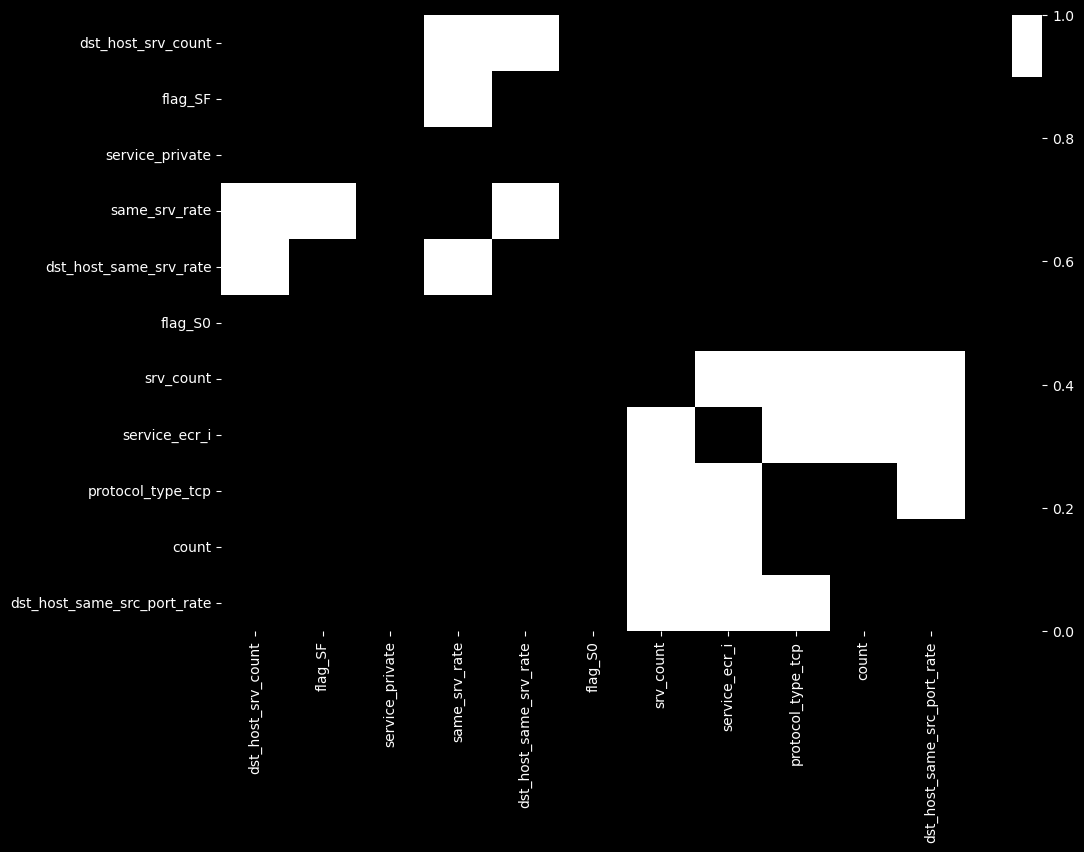

In [123]:
# Get all the features from the dictionary in the previous cell
left = [key for key, value in correl_dict.items() if value >= 4]
# remove Syn Error till it is urgent
left.remove('Syn Error')

# Define the dataframe X_left which has every feature with 5 or more colinearities
df_left = df[left]
# Create a heatmap of all the features that left
zero_diagonal_heatmap(df_left, color_map = ListedColormap(['black', 'white']), threshhold = 0.9) #type: ignore

From here we can see that there are two groupings of features that can be combined or eliminated. 
-  Top left: ['dst_host_srv_count', 'same_srv_rate', 'dst_host_same_srv_rate'] 
-  Bottom right corner: ['srv_count','service_ecr_i', 'dst_host_same_src_port_rate']

For the top left it makes sense to combine them since they are very highly correlated and are different ways of measuring the how often the same server was used. To do this we can create a new variable 'srvrate' that takes the rate features and spits out the max two of them. Similar to the Syn and Rej error we can try to capture some of the information of the columns without having colinearity problems.Since there is no way to combine 'dst_host_srv_count' and it is highly colinear I will drop it. 

For the bottom right there is no thread tying the three together but out of the three I can only keep one. I decided to keep 'protocol_type_tcp' because the other two have a massive correlation with count. If I keep 'protocol_type_tcp' then I can keep 'count'.

In [124]:
# Drop These columns that have no clear connection but are multi-colinear
df = df.drop(['srv_count','service_ecr_i', 'dst_host_same_src_port_rate'],axis = 1)

# Drop the non-rate column
df = df.drop('dst_host_srv_count', axis = 1)

# Create the srv_rate column
srvrate = ['dst_host_same_srv_rate', 'same_srv_rate']

# Define srvrate
df['srv_rate'] = df[srvrate].max(axis = 1)

While I have eliminated a lot of bad features, I still have a lot to go. I can use the same function again to see how I am doing.

In [125]:
# Find the worst multicolinear offenders.
corr_dict(df)

{'srv_rate': 6, 'flag_SF': 6, 'service_private': 6, 'dst_host_same_srv_rate': 6, 'flag_S0': 6, 'same_srv_rate': 6, 'Syn Error': 6, 'hot': 2, 'is_guest_login': 2, 'service_ftp': 2, 'num_compromised': 2, 'Rej Error': 1, 'service_http': 1, 'protocol_type_tcp': 1, 'dst_host_diff_srv_rate': 1, 'count': 1, 'flag_REJ': 1, 'service_other': 1, 'num_root': 1, 'logged_in': 1, 'su_attempted': 1}


In [17]:
correlations2 = {}
still_high_mcl = list(corr_dict.keys())
still_corr = pd.DataFrame(X[still_high_mcl].corr())
for shm in still_high_mcl:
    corrs2 = still_corr.index[abs(still_corr[shm]) > .4].tolist()
    corrs2.remove(shm)
    correlations2.update({shm: corrs2})
print(correlations2)

{'dst_host_srv_diff_host_rate': ['service_eco_i', 'dst_host_count'], 'dst_host_diff_srv_rate': ['duration', 'diff_srv_rate'], 'duration': ['dst_host_diff_srv_rate'], 'num_access_files': ['num_compromised'], 'service_eco_i': ['dst_host_srv_diff_host_rate'], 'service_smtp': ['srv_diff_host_rate'], 'protocol_type_udp': ['service_domain_u'], 'dst_host_count': ['dst_host_srv_diff_host_rate'], 'service_domain_u': ['protocol_type_udp'], 'diff_srv_rate': ['dst_host_diff_srv_rate'], 'srv_diff_host_rate': ['service_smtp'], 'num_compromised': ['num_access_files']}


In [13]:
# drop the srvrate columns
df = df.drop(srvrate, axis = 1)

# Drop these features as well for MCL and they aren't as good as their colinearities
df = df.drop(['flag_S0', 'flag_REJ', 'flag_SF', 'service_private','service_ftp','num_root',
              'srv_rate', 'service_http','protocol_type_tcp', 'is_guest_login','service_other',
              'su_attempted'], axis = 1)

# The vif score was too high so I had to see if dropping it would give a better chance
df = df.drop(['logged_in','count'], axis = 1)

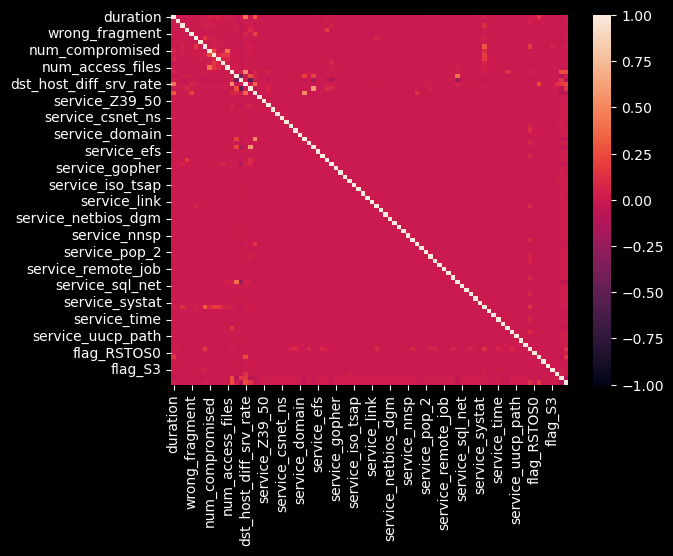

In [15]:
sns.heatmap(df.corr(), vmin = -1, vmax = 1);

In [24]:
#calculate the vif for the dataframe to see if it is non colinear
vif = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
# Put those numbers into a dictionary
vif_dict = {df.columns[i]:vif[i] for i in range(df.shape[1])}

In [25]:
print(f"{len(vif_dict)} out of {len(df.columns)} features have a vif < 2.5")
sorted_vif_dict = {k:v for k, v in sorted(vif_dict.items(), key=lambda item: item[1])}
print(sorted_vif_dict)
print(sorted_vif_dict.keys())

88 out of 88 features have a vif > 2.5
{'service_red_i': 1.0000102365355767, 'service_tftp_u': 1.0001329981317182, 'service_urh_i': 1.0001692828807274, 'flag_S2': 1.0002671933493479, 'service_tim_i': 1.0003036694746812, 'service_X11': 1.0003065008890066, 'service_pm_dump': 1.0003468958481274, 'service_Z39_50': 1.0006615228809326, 'service_netstat': 1.0007058644771067, 'service_name': 1.0007065623625526, 'service_http_443': 1.0007233376699465, 'service_kshell': 1.0007287994783514, 'service_netbios_ns': 1.0007351455658093, 'service_pop_2': 1.0007359308829968, 'service_netbios_dgm': 1.0007361537325334, 'service_link': 1.0007390135902179, 'service_ldap': 1.000746444423222, 'service_hostnames': 1.0007549729600922, 'service_bgp': 1.0007571365800938, 'service_netbios_ssn': 1.0007634589472487, 'service_klogin': 1.0007638787083206, 'service_uucp_path': 1.0007660095596553, 'service_vmnet': 1.0007708527011099, 'service_nnsp': 1.0007714031258061, 'service_mtp': 1.000774703883554, 'service_whois': 

This result is a major problem. While it may have seemed as though there were a lot of features to work with, instead most of the features are multicolinear and will need to be dropped. The first step is to see how many of the multicolinear variables are from dummy columns vs. the initial features.

In [26]:
# Create Lasso model
lasso = Lasso(max_iter = 50000)

# Define hyperparameter grid with a value less than 00.5 since that was the be
params = {'alpha': np.linspace(.001, .01, 20)}

# Perform grid search
grid_search = GridSearchCV(estimator=lasso, param_grid=params, cv=8)
grid_search.fit(df, y)

# Print best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)


Best hyperparameters:  {'alpha': 0.0024210526315789475}


In [27]:
# Find the coefficients of lasso regularization
lasso = Lasso(alpha = .005)
lasso.fit(df,y)
lasso_dict = {df.columns[i]:lasso.coef_[i] for i in range(len(df.columns)) if list(lasso.coef_)[i] != 0}
lasso_features = [df.columns[i] for i in range(len(df.columns)) if list(lasso.coef_)[i] != 0]
print(lasso_dict)
print(len(lasso_dict))

{'land': 0.0014732618722640737, 'wrong_fragment': 0.039026981701800946, 'num_access_files': -0.009325807435201514, 'srv_diff_host_rate': -0.031499801632908456, 'dst_host_count': 0.23968517917859433, 'dst_host_srv_diff_host_rate': 0.02209267466557662, 'protocol_type_udp': -0.16049020757374774, 'service_auth': -0.003496280480545223, 'service_domain_u': 0.010145106419848945, 'service_eco_i': 0.02755470142695862, 'service_finger': -0.006627901015223203, 'service_ftp_data': -0.015636766740260263, 'service_ntp_u': 0.0011152275376798094, 'service_smtp': -0.03906361794350795, 'service_urp_i': -0.023698806404193522, 'Syn Error': 0.03058389406852177, 'Rej Error': 0.008728496070236999}
17


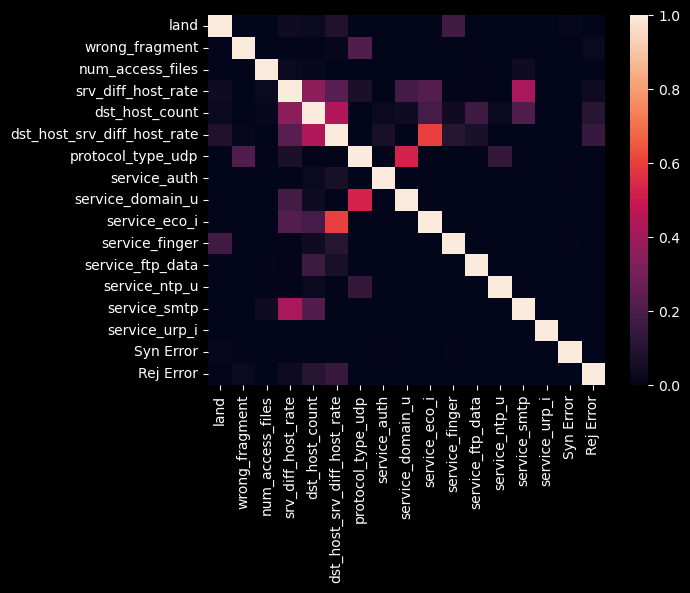

In [29]:
sns.heatmap(abs(df[list(lasso_dict.keys())]).corr(), vmin = 0, vmax = 1);

In [30]:
lasso_df_features = df[list(lasso_dict.keys())]

Now that we have a dataframe that is not supposed to have a colinearity problem we can test this one more time with the variance inflation score.

In [31]:
# Create a list vif that stores all of the vif values for each of the features
vif2 = [variance_inflation_factor(lasso_df_features, i) for i in range(len(lasso_df_features.columns))]
# Bind the features to their vif value for analysis, only keep the features with vif>2
vif2_dict = {lasso_df_features.columns[i]:[vif2[i], v]  for i,v in enumerate(lasso_dict.values())}
print(vif2_dict)
len(vif2_dict)

{'land': [1.0405986585801834, 0.0014732618722640737], 'wrong_fragment': [1.0716648432285443, 0.039026981701800946], 'num_access_files': [1.0022384381523786, -0.009325807435201514], 'srv_diff_host_rate': [1.4624753026799295, -0.031499801632908456], 'dst_host_count': [1.6147263348493337, 0.23968517917859433], 'dst_host_srv_diff_host_rate': [2.1430310726350834, 0.02209267466557662], 'protocol_type_udp': [1.5419619244215703, -0.16049020757374774], 'service_auth': [1.0070249264684952, -0.003496280480545223], 'service_domain_u': [1.4898409021527188, 0.010145106419848945], 'service_eco_i': [1.6437485541351613, 0.02755470142695862], 'service_finger': [1.0462352175274678, -0.006627901015223203], 'service_ftp_data': [1.0436046491902566, -0.015636766740260263], 'service_ntp_u': [1.0298064492473002, 0.0011152275376798094], 'service_smtp': [1.2659249666717631, -0.03906361794350795], 'service_urp_i': [1.0005243647507938, -0.023698806404193522], 'Syn Error': [1.0479782032248357, 0.03058389406852177],

17

<AxesSubplot:>

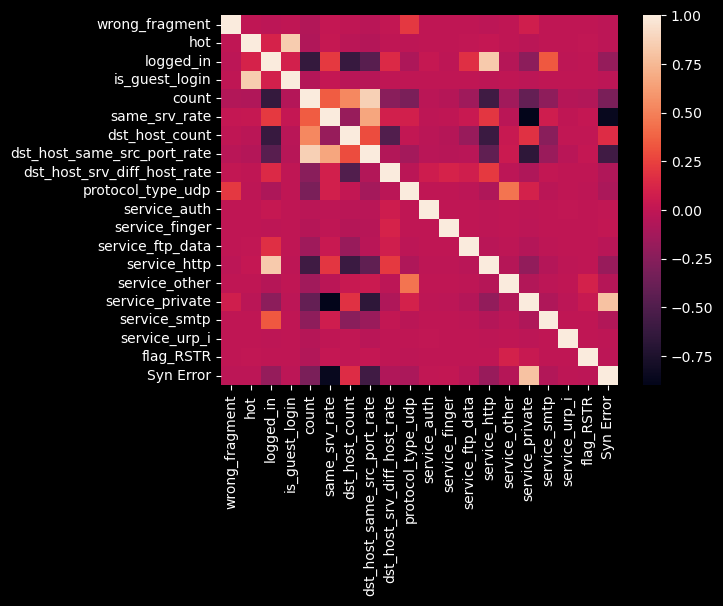

In [73]:
sns.heatmap(lasso_df_features.corr())

In [17]:
# Store the path in a variable so that it is easy to use
path =  r'C:\Users\jdrel\OneDrive\Documents\Data_Science\Springboard\Capstone-2\data\interim\KDD Data.csv'
# Save the data in a csv file
data.to_csv(path)